# Installing packages

In [0]:
!nvidia-smi # P100

Wed May 13 23:04:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    435MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!git clone https://github.com/klinime/Tiny_Imagenet_200.git
!pip install neural_structured_learning
!pip install tf-nightly

fatal: destination path 'Tiny_Imagenet_200' already exists and is not an empty directory.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import neural_structured_learning as nsl

from google.colab import drive
drive.mount('/content/gdrive')
import pathlib
import os

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

PATH = '/content/gdrive/My Drive/CS182_Project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Preprocessing

In [0]:
IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

In [0]:
class HParams(object):
  def __init__(self):
    self.img_dim = 64
    self.num_classes = 200
    self.lr = 0.01
    self.val_ratio = 10
    self.batch_size = 128
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

In [0]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm,
)

In [0]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.2,
    adv_step_size=0.2,
    adv_grad_norm='infinity',
)

In [0]:
# Data augmentation based on:
# https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

def hflip(img: tf.Tensor) -> tf.Tensor:
  return tf.image.random_flip_left_right(img)

# interpolation pads 0 instead, undesired so not used
# import tensorflow_addons as tfa
# def random_rotate(img: tf.Tensor) -> tf.Tensor:
#   return tfa.image.rotate(img, tf.random.uniform([], -0.5, 0.5))

def random_crop(img: tf.Tensor) -> tf.Tensor:
  return tf.image.random_crop(tf.image.resize(
    img, tf.shape(img)[:2]+16), tf.shape(img))

def color_jitter(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.random_hue(img, 0.04)
  img = tf.image.random_saturation(img, 0.4, 1.6)
  img = tf.image.random_brightness(img, 0.08)
  img = tf.image.random_contrast(img, 0.7, 1.3)
  return img

def noise_salt_pepper(img: tf.Tensor) -> tf.Tensor:
  mask_img = K.random_binomial(shape=tf.shape(img), p=0.01)
  mask_noise = K.random_binomial(shape=tf.shape(img), p=0.5)
  out = img * (1 - mask_img) + mask_noise * mask_img
  # Issue: https://github.com/tensorflow/tensorflow/issues/24520
  out.set_shape([None, None, None])
  return out

def noise_gaussian(img: tf.Tensor) -> tf.Tensor:
  out = img + tf.random.normal(tf.shape(img), 0, tf.sqrt(0.01))
  # Issue: https://github.com/tensorflow/tensorflow/issues/24520
  out.set_shape([None, None, None])
  return out

def noise_poisson(img: tf.Tensor) -> tf.Tensor:
  # idk what im doing for this one, but it kinda works
  vals = tf.cast(tf.math.reduce_prod(tf.shape(img)), tf.float32)
  vals = tf.math.exp(tf.math.floor(tf.math.log(vals)))
  out = tf.squeeze(tf.random.poisson([1], img * vals)) / vals
  # Issue: https://github.com/tensorflow/tensorflow/issues/24520
  out.set_shape([None, None, None])
  return out

# Image loading based on:
# https://www.tensorflow.org/tutorials/load_data/images

AUTOTUNE = tf.data.experimental.AUTOTUNE
class_names = np.array(sorted(
    [item.name for item in pathlib.Path('Tiny_Imagenet_200/data/tiny-imagenet-200/train/').glob('*')]))
# print(class_names)

def load_data(folder):
  train_dir = pathlib.Path(folder + 'train/')
  train_image_count = len(list(train_dir.glob('**/*.JPEG')))
  train_list_ds = tf.data.Dataset.list_files(str(train_dir/'*/images/*'))
  print('Discovered {} images for training data.'.format(train_image_count))

  val_dir = pathlib.Path(folder + 'val/')
  val_image_count = len(list(val_dir.glob('*/*.JPEG')))
  val_path = str(val_dir/'images')
  val_list_ds = tf.data.Dataset.from_tensor_slices(
      sorted(['{}/{}'.format(val_path, item.name) for item in val_dir.glob('images/*')],
             key=lambda x: int(x[x.rfind('_')+1:x.find('.')])))
  i = 0
  for elem in val_list_ds:
    print(elem)
    i += 1
    if i > 2:
      break

  val_label_ds = tf.data.TextLineDataset(str(val_dir/'val_annotations.txt'))
  val_label_ds = val_label_ds.map(
      lambda x: tf.argmax(tf.dtypes.cast(tf.strings.split(x, '\t')[1] == class_names, tf.int32), axis=0), 
      num_parallel_calls=AUTOTUNE, deterministic=True)
  i = 0
  for elem in val_label_ds:
    print(class_names[elem])
    i += 1
    if i > 2:
      break
  print('Discovered {} images for validation data.'.format(val_image_count))

  test_dir = pathlib.Path(folder + 'test/')
  test_image_count = len(list(test_dir.glob('*/*.JPEG')))
  test_list_ds = tf.data.Dataset.list_files(str(test_dir/'images/*'))
  print('Discovered {} images for test data.'.format(test_image_count))

  def process_path(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # third to last is the class-directory
    label = parts[-3] == class_names
    # print('label', label)
    
    label = tf.dtypes.cast(label, tf.int32)
    label = tf.argmax(label, axis=0)
    # print('label_after', label)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # use 'convert_image_dtype' to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label
  
  def process_images(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img
  
  train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
  # print('train_labeled_ds')
  # for elem in train_labeled_ds:
  #   print(elem)
  #   print('in for loop')

  val_img_ds = val_list_ds.map(process_images, num_parallel_calls=AUTOTUNE, deterministic=True)
  i = 0
  for elem in val_img_ds:
    print(elem)
    i += 1
    if i > 2:
      break
  val_labeled_ds = tf.data.Dataset.zip((val_img_ds, val_label_ds))

  test_ds = test_list_ds.map(process_images, num_parallel_calls=AUTOTUNE, deterministic=True)
  return class_names, train_image_count, train_labeled_ds, \
    val_image_count, val_labeled_ds, test_image_count, test_ds

def prepare_for_training(ds, batch_size, cache=True, shuffle_buffer_size=1000):
  # use '.cache(filename)' to cache preprocessing work for big datasets
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  for augment in [hflip, random_crop, color_jitter]:
    ds = ds.map(lambda img, label: (tf.cond(tf.random.uniform([], 0, 1) < 0.5, 
        lambda: augment(img), lambda: img), label), num_parallel_calls=AUTOTUNE)
  for augment in [noise_salt_pepper, noise_gaussian, noise_poisson]:
    ds = ds.map(lambda img, label: (tf.cond(tf.random.uniform([], 0, 1) < 0.2, 
        lambda: augment(img), lambda: img), label), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda img, label: (tf.clip_by_value(img, 0, 1), label), 
              num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda img, label: (tf.image.per_image_standardization(img), label),
              num_parallel_calls=AUTOTUNE)
  
  ds = ds.shuffle(buffer_size=shuffle_buffer_size).repeat().batch(batch_size)
  # 'prefetch' fetches batches in the background while the model is training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_validation(ds, batch_size, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size).batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [0]:
def create_model(name, img_dim, up_ratio, num_classes):
  img = keras.Input(shape=(img_dim, img_dim, 3), dtype='float32', name='image')
  upsample = keras.layers.UpSampling2D(up_ratio, name='upsample')
  base_model = keras.applications.EfficientNetB2(
      input_shape=(img_dim * up_ratio, img_dim * up_ratio, 3),
      include_top=False,
      pooling='avg'
  )
  base_model.summary()
  base_model.trainable = False
  prediction = keras.layers.Dense(num_classes, name='prediction')
  out = prediction(base_model(upsample(img)))
  return keras.Model(inputs=img, outputs=out, name=name)

# def create_model(name, img_dim, up_ratio, num_classes):
#   img = keras.Input(shape=(img_dim, img_dim, 3), dtype='float32', name='image')
#   upsample = keras.layers.UpSampling2D(up_ratio, name='upsample')
#   base_model = keras.applications.NASNetLarge(
#     input_shape=(img_dim * up_ratio, img_dim * up_ratio, 3),
#     include_top=False,
#     weights=None,
#     pooling='avg'
#   )
#   base_model.load_weights(PATH + 'NASNet-large-no-top.h5')
#   base_model.trainable = False
#   prediction = keras.layers.Dense(num_classes, name='prediction')
#   out = prediction(base_model(upsample(img)));
#   return keras.Model(inputs=img, outputs=out, name=name)

tf.random.set_seed(0) # is not deterministic though
img_dim = HPARAMS.img_dim
#change to 16 for robustness section
batch_size = HPARAMS.batch_size
lr = HPARAMS.lr
val_ratio =HPARAMS.val_ratio

data = load_data('Tiny_Imagenet_200/data/tiny-imagenet-200/')
classes = data[0]
train_count, train_data = data[1:3]
val_count, val_data = data[3:5]
test_count, test_data = data[5:]
train_data = prepare_for_training(train_data, batch_size)
val_data = prepare_for_validation(val_data, batch_size)
steps_per_epoch = np.ceil(train_count / batch_size)
validation_steps = np.ceil(val_count / batch_size / val_ratio)

Discovered 100000 images for training data.
tf.Tensor(b'Tiny_Imagenet_200/data/tiny-imagenet-200/val/images/val_0.JPEG', shape=(), dtype=string)
tf.Tensor(b'Tiny_Imagenet_200/data/tiny-imagenet-200/val/images/val_1.JPEG', shape=(), dtype=string)
tf.Tensor(b'Tiny_Imagenet_200/data/tiny-imagenet-200/val/images/val_2.JPEG', shape=(), dtype=string)
n03444034
n04067472
n04070727
Discovered 10000 images for validation data.
Discovered 10000 images for test data.
tf.Tensor(
[[[0.14509805 0.18823531 0.19607845]
  [0.70980394 0.7137255  0.73333335]
  [0.7843138  0.7058824  0.75294125]
  ...
  [0.59607846 0.6156863  0.5372549 ]
  [0.53333336 0.5647059  0.48235297]
  [0.50980395 0.5411765  0.45098042]]

 [[0.03529412 0.10588236 0.10588236]
  [0.02352941 0.05490196 0.06666667]
  [0.22352943 0.17254902 0.21176472]
  ...
  [0.5058824  0.52156866 0.454902  ]
  [0.45098042 0.48235297 0.40000004]
  [0.46274513 0.49411768 0.41176474]]

 [[0.7568628  0.8862746  0.8588236 ]
  [0.80392164 0.89019614 0.8784

In [0]:
train_data_adv = train_data.map(convert_to_dictionaries, num_parallel_calls=AUTOTUNE)
val_data_adv = val_data.map(convert_to_dictionaries)

In [0]:
# Based on tfds.show_examples, make sure to disable batch and prefetch

def visualize():
  from tensorflow_datasets.core import dataset_utils
  from matplotlib import pyplot as plt

  ds = train_data
  rows, cols, plot_scale = 5, 5, 3
  num_examples = rows * cols
  examples = list(dataset_utils.as_numpy(ds.take(num_examples)))

  fig = plt.figure(figsize=(plot_scale*cols, plot_scale*rows))
  fig.subplots_adjust(hspace=1/plot_scale, wspace=1/plot_scale)
  for i, (image, label) in enumerate(examples):
    ax = fig.add_subplot(rows, cols, i+1)
    # Plot the image
    ax.imshow(image, cmap="gray")
    ax.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])
  plt.show()

# Base Model

In [0]:
#create base model
base_model = create_model('base_model', img_dim, 4, len(classes))
base_learning_rate = 0.01
base_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
base_model.summary()

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(PATH + 'checkpoint/ckpt_{epoch:03d}')
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

def train_base_model():
  initial_epochs = 10
  # import pdb; pdb.set_trace()
  history = base_model.fit(
      train_data,
      epochs=initial_epochs,
      # epochs=initial_epochs,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_data,
      validation_steps=validation_steps,
      callbacks=[ckpt_callback, tsb_callback],
      # verbose=2
  )
  
train_base_model()
# Note: google colab has single core, blocking callbacks and 
# concurrent validation at epoch end and in favor of the training process.

In [0]:
#evaluate base model, might need to change val_data to val_data_adv
results = base_model.evaluate(val_data)
named_results = dict(zip(base_model.metrics_names, results))
print('sparse_categorical_crossentropy', named_results['sparse_categorical_crossentropy'])
print('sparse_categorical_accuracy', named_results['sparse_categorical_accuracy'])
print('sparse_top_k_categorical_accuracy', named_results['sparse_top_k_categorical_accuracy'])

# Adversarial-regularized model

In [0]:
#create adv model
base_adv_model = create_model('base_adv_model', img_dim, 2, len(classes))
adv_model = nsl.keras.AdversarialRegularization(base_adv_model, label_keys=['label'], adv_config=adv_config)
adv_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# adv_model.summary()

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(PATH + 'checkpoint/adv_ckpt_{epoch:03d}')
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

def train_adv_model():
  initial_epochs = 5
  # import pdb; pdb.set_trace()
  history = adv_model.fit(
      train_data_adv,
      epochs=initial_epochs,
      # epochs=initial_epochs,
      steps_per_epoch=steps_per_epoch,
      # validation_data=val_data_adv,
      validation_steps=validation_steps,
      callbacks=[ckpt_callback, tsb_callback],
      # verbose=2
  )
train_adv_model()
# Note: google colab has single core, blocking callbacks and 
# concurrent validation at epoch end and in favor of the training process.

In [0]:
#evaluate adv model
results = adv_model.evaluate(val_data_adv)
named_results = dict(zip(adv_model.metrics_names, results))
print('sparse_categorical_crossentropy', named_results['sparse_categorical_crossentropy'])
print('sparse_categorical_accuracy', named_results['sparse_categorical_accuracy'])
print('sparse_top_k_categorical_accuracy', named_results['sparse_top_k_categorical_accuracy'])

#Finetune Training Base Model

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(PATH + 'checkpoint/ckpt_finetune_0_{epoch:03d}')
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = base_model.get_layer(name='NASNet')
NASNET.trainable = True
finetune_layer_0 = -93
print('Start finetuning at {}'.format(NASNET.layers[finetune_layer_0].name))
for layer in NASNET.layers[:finetune_layer_0]:
  layer.trainable = False
base_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
base_model.summary()

finetune_epochs_0 = 10
total_epochs = 10
history_finetune_0 = base_model.fit(
    train_data,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

ValueError: ignored

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(PATH + 'checkpoint/ckpt_finetune_1_{epoch:03d}')
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = base_model.get_layer(name='NASNet')
NASNET.trainable = True
finetune_layer_1 = -183
print('Start finetuning at {}'.format(NASNET.layers[finetune_layer_1].name))
for layer in NASNET.layers[:finetune_layer_1]:
  layer.trainable = False
base_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
base_model.summary()

finetune_epochs_1 = 10
total_epochs = 10
history_finetune_1 = base_model.fit(
    train_data,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Start finetuning at normal_concat_14
Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
upsample (UpSampling2D)      (None, 128, 128, 3)       0         
_________________________________________________________________
NASNet (Model)               (None, 4032)              84916818  
_________________________________________________________________
prediction (Dense)           (None, 200)               806600    
Total params: 85,723,418
Trainable params: 41,024,456
Non-trainable params: 44,698,962
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 363s 232ms/step - loss: 1.9457 - sparse_categorical_crossentropy: 4.4708 - sparse_categorical_accuracy: 0.5318 - sparse_top_k_categorical_ac

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(PATH + 'checkpoint/ckpt_finetune_2_{epoch:03d}')
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = base_model.get_layer(name='NASNet')
NASNET.trainable = True
finetune_layer_2 = -330
print('Start finetuning at {}'.format(NASNET.layers[finetune_layer_2].name))
for layer in NASNET.layers[:finetune_layer_2]:
  layer.trainable = False
base_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
base_model.summary()

finetune_epochs_2 = 0
total_epochs = 10
history_finetune_2 = base_model.fit(
    train_data,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Start finetuning at normal_concat_12
Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
upsample (UpSampling2D)      (None, 128, 128, 3)       0         
_________________________________________________________________
NASNet (Model)               (None, 4032)              84916818  
_________________________________________________________________
prediction (Dense)           (None, 200)               806600    
Total params: 85,723,418
Trainable params: 65,424,776
Non-trainable params: 20,298,642
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 446s 285ms/step - loss: 1.3238 - sparse_categorical_crossentropy: 4.4005 - sparse_categorical_accuracy: 0.6724 - sparse_top_k_categorical_ac

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(PATH + 'checkpoint/ckpt_finetune_all_{epoch:03d}')
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = base_model.get_layer(name='NASNet')
for layer in NASNET.layers[:-330]:
  layer.trainable = True
base_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
base_model.summary()

finetune_epochs_all = 0
total_epochs = 10
history_finetune_all = base_model.fit(
    train_data,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
upsample (UpSampling2D)      (None, 128, 128, 3)       0         
_________________________________________________________________
NASNet (Model)               (None, 4032)              84916818  
_________________________________________________________________
prediction (Dense)           (None, 200)               806600    
Total params: 85,723,418
Trainable params: 806,600
Non-trainable params: 84,916,818
_________________________________________________________________
Epoch 1/10
1563/1563 [==============================] - 272s 174ms/step - loss: 1.5304 - sparse_categorical_crossentropy: 4.4311 - sparse_categorical_accuracy: 0.6285 - sparse_top_k_categorical_accuracy: 0.8349
Epoch 2/10
1563/1563 [===

#Finetune Training Adversarial-regularized Model


In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(
    PATH + 'checkpoint/adv_ckpt_finetune_0',
    save_weights_only=True # full model save errors when using mixed_precision
)
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = adv_model.base_model.get_layer(name='NASNet')
NASNET.trainable = True
finetune_layer_0 = -93
print('Start finetuning at {}'.format(NASNET.layers[finetune_layer_0].name))
for layer in NASNET.layers[:finetune_layer_0]:
  layer.trainable = False
adv_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# base_model.summary()

finetune_epochs_0 = 0
total_epochs = 10
history_finetune_0 = adv_model.fit(
    train_data_adv,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Start finetuning at normal_concat_16
Epoch 1/10
1563/1563 [==============================] - 1023s 655ms/step - loss: 3.8108 - sparse_categorical_crossentropy: 2.7671 - sparse_categorical_crossentropy_2: 4.6830 - sparse_categorical_accuracy: 0.4087 - sparse_top_k_categorical_accuracy: 0.6423 - adversarial_loss: 5.2186
Epoch 2/10
1563/1563 [==============================] - 1021s 653ms/step - loss: 3.5749 - sparse_categorical_crossentropy: 2.5237 - sparse_categorical_crossentropy_2: 4.6006 - sparse_categorical_accuracy: 0.4347 - sparse_top_k_categorical_accuracy: 0.6716 - adversarial_loss: 5.2561
Epoch 3/10
1563/1563 [==============================] - 1020s 653ms/step - loss: 3.4812 - sparse_categorical_crossentropy: 2.4334 - sparse_categorical_crossentropy_2: 4.5724 - sparse_categorical_accuracy: 0.4469 - sparse_top_k_categorical_accuracy: 0.6844 - adversarial_loss: 5.2394
Epoch 4/10
1563/1563 [==============================] - 1019s 652ms/step - loss: 3.5041 - sparse_categorical_cross

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(
    PATH + 'checkpoint/adv_ckpt_finetune_1',
    save_weights_only=True # full model save errors when using mixed_precision
)
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = adv_model.base_model.get_layer(name='NASNet')
NASNET.trainable = True
finetune_layer_1 = -183
print('Start finetuning at {}'.format(NASNET.layers[finetune_layer_1].name))
for layer in NASNET.layers[:finetune_layer_1]:
  layer.trainable = False
adv_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# base_model.summary()

finetune_epochs_1 = 0
total_epochs = 10
history_finetune_1 = adv_model.fit(
    train_data_adv,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Start finetuning at normal_concat_14
Epoch 1/10
1563/1563 [==============================] - 1109s 710ms/step - loss: 2.9348 - sparse_categorical_crossentropy: 1.9574 - sparse_categorical_crossentropy_2: 4.4575 - sparse_categorical_accuracy: 0.5327 - sparse_top_k_categorical_accuracy: 0.7650 - adversarial_loss: 4.8870
Epoch 2/10
1563/1563 [==============================] - 1107s 708ms/step - loss: 2.8520 - sparse_categorical_crossentropy: 1.8858 - sparse_categorical_crossentropy_2: 4.4430 - sparse_categorical_accuracy: 0.5463 - sparse_top_k_categorical_accuracy: 0.7763 - adversarial_loss: 4.8311
Epoch 3/10
1563/1563 [==============================] - 1108s 709ms/step - loss: 2.8069 - sparse_categorical_crossentropy: 1.8586 - sparse_categorical_crossentropy_2: 4.4525 - sparse_categorical_accuracy: 0.5511 - sparse_top_k_categorical_accuracy: 0.7789 - adversarial_loss: 4.7416
Epoch 4/10
1563/1563 [==============================] - 1107s 708ms/step - loss: 2.6376 - sparse_categorical_cross

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(
    PATH + 'checkpoint/adv_ckpt_finetune_2',
    save_weights_only=True # full model save errors when using mixed_precision
)
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

NASNET = adv_model.base_model.get_layer(name='NASNet')
NASNET.trainable = True
finetune_layer_2 = -330
print('Start finetuning at {}'.format(NASNET.layers[finetune_layer_2].name))
for layer in NASNET.layers[:finetune_layer_2]:
  layer.trainable = False
adv_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# base_model.summary()

finetune_epochs_2 = 0
total_epochs = 10
history_finetune_2 = adv_model.fit(
    train_data_adv,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Start finetuning at normal_concat_12
Epoch 1/10
1563/1563 [==============================] - 1273s 815ms/step - loss: 2.1851 - sparse_categorical_crossentropy: 1.3284 - sparse_categorical_crossentropy_2: 4.4267 - sparse_categorical_accuracy: 0.6717 - sparse_top_k_categorical_accuracy: 0.8594 - adversarial_loss: 4.2839
Epoch 2/10
1563/1563 [==============================] - 1271s 813ms/step - loss: 1.9595 - sparse_categorical_crossentropy: 1.1225 - sparse_categorical_crossentropy_2: 4.4120 - sparse_categorical_accuracy: 0.7257 - sparse_top_k_categorical_accuracy: 0.8887 - adversarial_loss: 4.1851
Epoch 3/10
1563/1563 [==============================] - 1272s 814ms/step - loss: 2.0990 - sparse_categorical_crossentropy: 1.2529 - sparse_categorical_crossentropy_2: 4.4194 - sparse_categorical_accuracy: 0.6873 - sparse_top_k_categorical_accuracy: 0.8691 - adversarial_loss: 4.2304
Epoch 4/10
1563/1563 [==============================] - 1270s 813ms/step - loss: 1.9908 - sparse_categorical_cross

In [0]:
ckpt_callback = keras.callbacks.ModelCheckpoint(
    PATH + 'checkpoint/adv_ckpt_finetune_all',
    save_weights_only=True # full model save errors when using mixed_precision
)
tsb_callback = keras.callbacks.TensorBoard(log_dir=PATH+'logs')

print('Finetune all')
NASNET = adv_model.base_model.get_layer(name='NASNet')
for layer in NASNET.layers[:finetune_layer_2]:
  layer.trainable = True
adv_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# base_model.summary()

finetune_epochs_3 = 0
total_epochs = 10
history_finetune_1 = adv_model.fit(
    train_data_adv,
    epochs=total_epochs,
    # initial_epoch = 10,
    # initial_epoch = history.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    callbacks=[ckpt_callback, tsb_callback],
    # verbose=2
)

Finetune all
Epoch 1/10
1563/1563 [==============================] - 2365s 2s/step - loss: 1.5601 - sparse_categorical_crossentropy: 0.8567 - sparse_categorical_crossentropy_2: 4.3874 - sparse_categorical_accuracy: 0.7727 - sparse_top_k_categorical_accuracy: 0.9281 - adversarial_loss: 3.5173
Epoch 2/10
1563/1563 [==============================] - 2360s 2s/step - loss: 1.2311 - sparse_categorical_crossentropy: 0.5896 - sparse_categorical_crossentropy_2: 4.3834 - sparse_categorical_accuracy: 0.8415 - sparse_top_k_categorical_accuracy: 0.9590 - adversarial_loss: 3.2078
Epoch 3/10
1563/1563 [==============================] - 2358s 2s/step - loss: 1.1377 - sparse_categorical_crossentropy: 0.5214 - sparse_categorical_crossentropy_2: 4.3838 - sparse_categorical_accuracy: 0.8581 - sparse_top_k_categorical_accuracy: 0.9664 - adversarial_loss: 3.0817
Epoch 4/10
 129/1563 [=>............................] - ETA: 35:45 - loss: 1.1022 - sparse_categorical_crossentropy: 0.4890 - sparse_categorical_cr

In [0]:
print('Finetune all')
for layer in base_model.layers[:finetune_layer_2]:
  layer.trainable = True
model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr/1000, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_crossentropy', 'categorical_accuracy', 
                       'top_k_categorical_accuracy'])
model.summary()

finetune_epochs_3 = 50
total_epochs = total_epochs + finetune_epochs_3
history_finetune_3 = model.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch = history_finetune_2.epoch[-1],
    steps_per_epoch=steps_per_epoch,
    verbose=2
)

#Restore Models

In [0]:
#create new base model
base_model = create_model('base_model', img_dim, 2, len(classes))
base_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# Loads the weights
base_model.load_weights(PATH + 'checkpoint/ckpt_finetune_all')

In [0]:
#create adv model
base_adv_model = create_model('base_adv_model', img_dim, 2, len(classes))
adv_model = nsl.keras.AdversarialRegularization(base_adv_model, label_keys=['label'], adv_config=adv_config)
adv_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])
# Loads the weights
adv_model.load_weights(PATH + 'checkpoint/ckpt_154')

Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 128, 128, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

ValueError: ignored

#Robustness under Adversarial perturbations

In [0]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config)
#optimizer was adam in documentation
reference_model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 
                       'sparse_top_k_categorical_accuracy'])

In [0]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [0]:
perturbed_images, labels, predictions = [], [], []

i = 0

for batch in train_data_adv:
  i += 1
  print(i)
  if i > 100:
    break
  # print('batch', batch)
  #model used to be reference_model
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = np.argmax(y_pred.numpy(), axis=-1)
    # tf.argmax(y_pred, axis=-1).numpy()
    
    # 

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
base model accuracy: 0.044062


#Examples of adversarially-perturbed images

accuracy in batch 0:
base model: 0 / 64


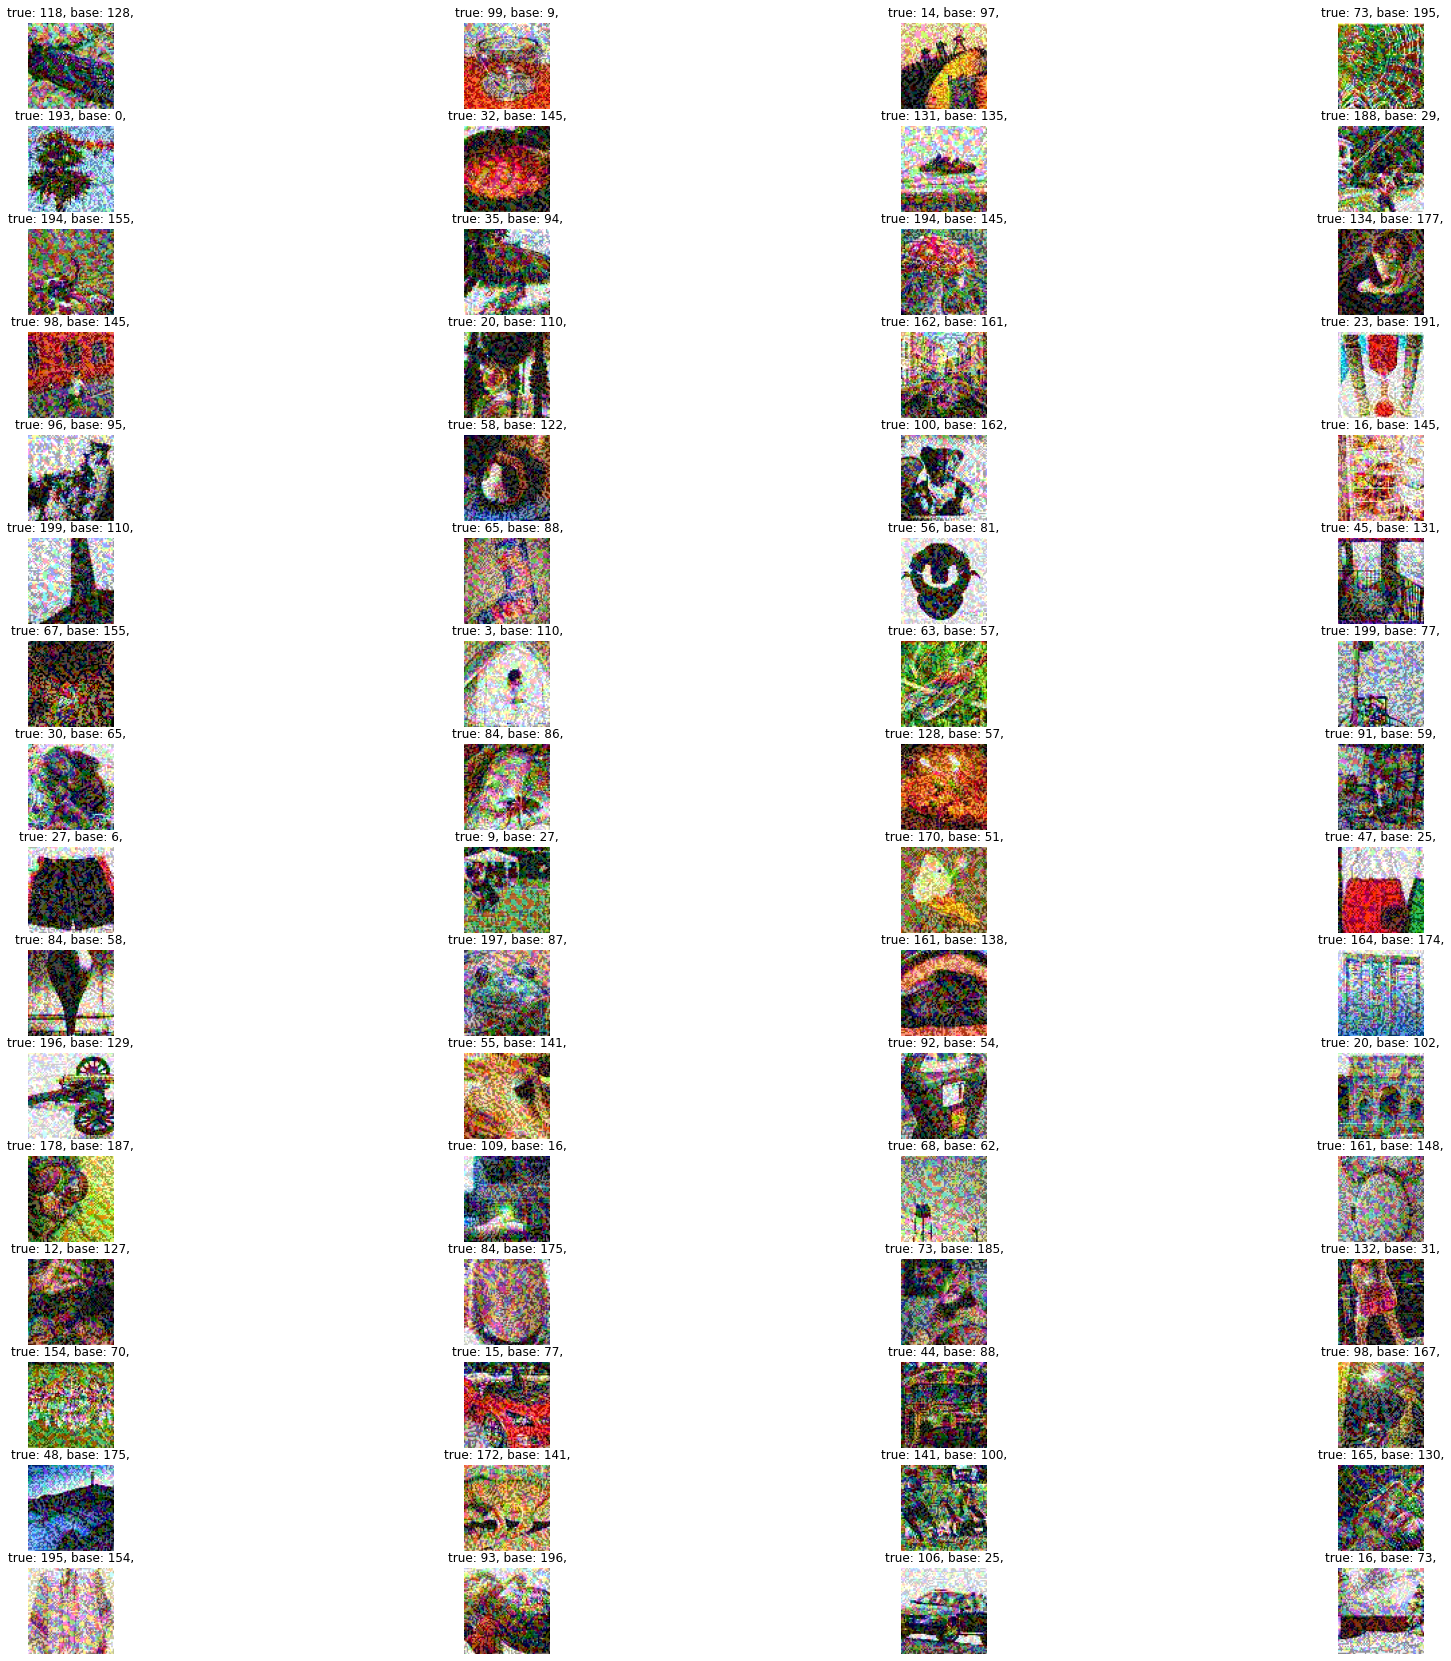

In [0]:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(30, 30))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  # plt.title('true: %d, base: %d,' % (y, y_base))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()